## Structure learning in decomposable graphical models

Two examples of the particle Gibbs sampler for Bayesian structure learning are shown in this section for both continuous and discrete data.

In [4]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import seaborn as sns

from trilearn.graph import trajectory
import trilearn.graph.graph as glib
import trilearn.graph.decomposable as dlib
import trilearn.distributions.g_intra_class as gic
import trilearn.auxiliary_functions as aux
from trilearn.distributions import discrete_dec_log_linear as loglin
from trilearn import pgibbs
sns.set_style("whitegrid")

### Discrete log-linear models

The first two rows (i.e. index 0 and 1), of the file should specify the labels and the levels of the corresponding variables. 

#### Czech auto workers data

In [5]:
aw_df = pd.read_csv("sample_data/czech_autoworkers.csv", header=[0, 1]) 

In [6]:
aw_df.head(2)

,A,B,C,D,E,F
,2,2,2,2,2,2
0,1,1,1,0,0,0
1,1,1,1,0,0,0


In [7]:
aw_df.shape

(1841, 6)

In [8]:
np.random.seed(1)
aw_graph_traj = pgibbs.sample_trajectory_loglin(dataframe=aw_df, n_particles=100, n_samples=1000, reset_cache=False)

Particle Gibbs samples: 100%|██████████| 1000/1000 [07:54<00:00,  2.45it/s]


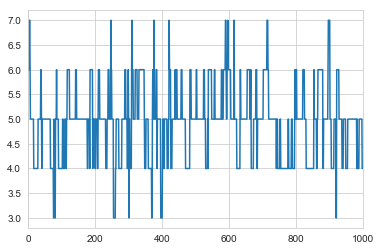

In [9]:
aw_graph_traj.size().plot();

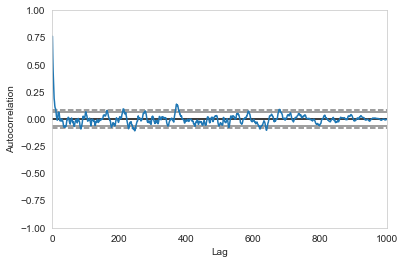

In [10]:
autocorrelation_plot(aw_graph_traj.size());

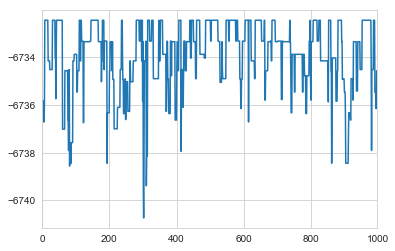

In [11]:
aw_graph_traj.log_likelihood().plot();

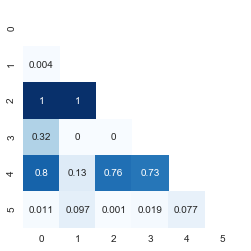

In [12]:
aux.plot_heatmap(aw_graph_traj.empirical_distribution().heatmap(), annot=True)

In [13]:
aw_top = aw_graph_traj.empirical_distribution().mode(5)
print("Probability\tEdge list: ")
for graph, prob in aw_top:
    print(str(prob)+ "\t\t"  + str(list(graph.edges())))

Probability	Edge list: 
0.311		[(0, 2), (0, 4), (1, 2), (2, 4), (3, 4)]
0.127		[(0, 2), (0, 3), (0, 4), (1, 2), (2, 4)]
0.09		[(0, 2), (0, 3), (0, 4), (1, 2), (2, 4), (3, 4)]
0.071		[(0, 2), (0, 4), (1, 2), (3, 4)]
0.064		[(0, 2), (1, 2), (1, 4), (3, 4)]


In [14]:
aw_mapgraph = aw_graph_traj.empirical_distribution().mode(1)[0][0]

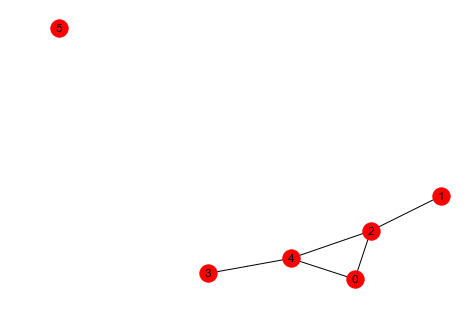

In [15]:
nx.draw(aw_mapgraph, with_labels=True)

### Gaussian graphical models (GGMs)

#### Simualted AR(1-5)-model

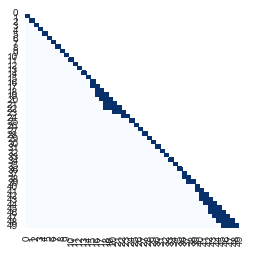

In [11]:
np.random.seed(2) # generates same data as in the paper
ar_graph = dlib.sample_random_AR_graph(n_dim=50, max_bandwidth=5)
aux.plot_heatmap(nx.to_numpy_array(ar_graph))
ar_cov_mat = gic.cov_matrix(ar_graph, 0.9, 1.0)
ar_df = pd.DataFrame(np.random.multivariate_normal(np.zeros(50), ar_cov_mat, 100))

In [12]:
ar_df.shape

(100, 50)

In [13]:
ar_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.878698,-1.044433,-0.994832,-0.540235,0.388393,-0.053121,-0.288285,-0.292727,0.000756,0.536629,...,-0.362839,0.565511,-0.003182,0.749745,0.745054,0.832351,0.238145,0.172086,0.232156,1.184147
1,-0.256525,-0.116048,-0.939653,-0.237265,-1.083843,0.096893,-0.206374,0.453107,0.623415,0.686505,...,-2.911721,-2.728024,-3.712332,-2.249938,-2.698523,-2.533075,-2.290659,-1.938907,-1.968094,-2.363825
2,-0.925658,-1.758184,-1.418430,-0.835956,-0.737220,-0.903629,-0.961176,-0.452963,-0.407657,-0.959168,...,0.179886,-0.221527,-0.534704,0.397889,0.031784,-0.145461,-0.029806,1.208847,0.151478,0.266227
3,0.875713,0.714240,0.231472,0.100144,-0.328630,0.270911,1.170769,0.077983,0.255248,0.499334,...,-0.990777,-1.127271,-0.766296,-0.707487,-0.726714,-1.034268,-1.021424,-0.440082,-0.467834,-0.910679
4,1.133365,0.993533,0.828134,-0.422246,0.047987,-0.316020,-0.254247,-0.465496,-0.699212,-0.252601,...,-0.275558,-0.300291,-0.661286,-0.582638,-0.851878,-0.349612,-0.672281,-0.501435,-0.250874,-0.759566


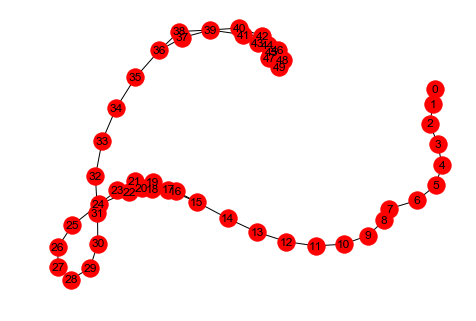

In [14]:
nx.draw(ar_graph, with_labels=True)

In [30]:
np.random.seed(1)

In [31]:
ar_graph_traj_seed1 = pgibbs.sample_trajectory_ggm(dataframe=ar_df, n_particles=50, alpha=0.5, beta=0.8, radius=5, n_samples=5000, reset_cache=True)

Particle Gibbs samples: 100%|██████████| 5000/5000 [9:29:53<00:00, 11.63s/it]


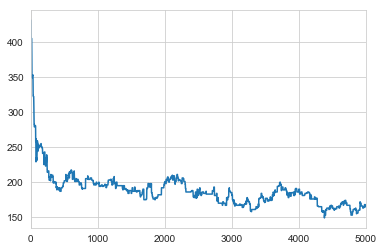

In [34]:
ar_graph_traj_seed1.size().plot();

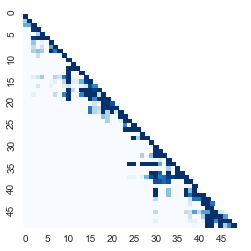

In [38]:
aux.plot_heatmap(ar_graph_traj_seed1.empirical_distribution(4500).heatmap(), xticklabels=5, yticklabels=5 )

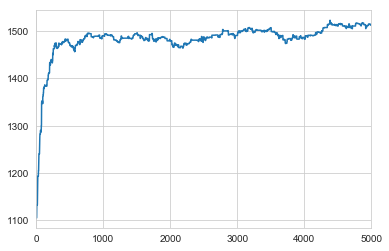

In [36]:
ar_graph_traj_seed1.logl =[]
ar_graph_traj_seed1.log_likelihood(0).plot();

In [15]:
ar_graph_traj = pgibbs.sample_trajectory_ggm(dataframe=ar_df, n_particles=50, alpha=0.5, beta=0.8, radius=5, n_samples=5000, reset_cache=True)

Particle Gibbs samples: 100%|██████████| 5000/5000 [10:32:17<00:00,  4.71s/it]


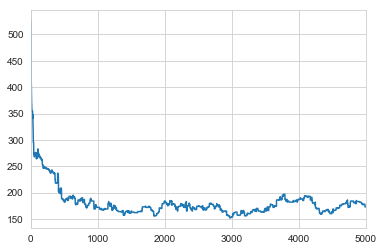

In [17]:
ar_graph_traj.size().plot();

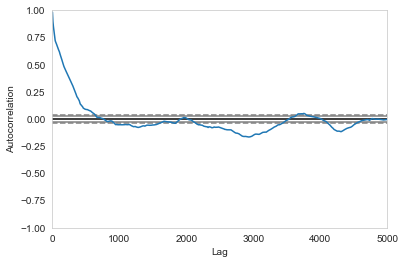

In [16]:
autocorrelation_plot(ar_graph_traj.size());

In [ ]:
nx.draw(ar_mapgraph, with_labels=True)

### Simulated 15 nodes log-linear model

In [ ]:
loglin_graph = nx.Graph()
loglin_graph.add_nodes_from(range(15))
loglin_graph.add_edges_from([(0, 11), (0, 7), (1, 8), (1, 6), (2, 4), (3, 8), (3, 9),
                             (3, 10), (3, 4), (3, 6), (4, 6), (4, 8), (4, 9), (4, 10),
                             (5, 10), (5, 6), (6, 8), (6, 9), (6, 10), (7, 11), (8, 9),
                             (8, 10), (8, 11), (9, 10), (10, 11), (12, 13)])

In [ ]:
aux.plot_heatmap(nx.to_numpy_array(loglin_graph))

In [ ]:
nx.draw(loglin_graph, with_labels=True)

In [ ]:
np.random.seed(1)
levels = np.array([range(2)] * loglin_graph.order())
table = loglin.sample_prob_table(loglin_graph, levels, 1.0)

In [ ]:
np.random.seed(5)
loglin_df = pd.DataFrame(loglin.sample(table, 1000))
loglin_df.columns = [range(loglin_graph.order()), [len(l) for l in levels]]

In [ ]:
loglin_df.head()

In [ ]:
loglin_df.shape

In [ ]:
loglin_graph_traj = pgibbs.sample_trajectory_loglin(dataframe=loglin_df, n_particles=100, alpha=0.2, beta=0.8, n_samples=10000, 
                                                    reset_cache=True)

In [ ]:
loglin_graph_traj.size().plot();

In [ ]:
autocorrelation_plot(loglin_graph_traj.size());

In [ ]:
loglin_graph_traj.log_likelihood().plot();

In [ ]:
aux.plot_heatmap(loglin_graph_traj.empirical_distribution(5).heatmap())

In [ ]:
loglin_mapgraph = loglin_graph_traj.empirical_distribution().mode(1)[0][0]
aux.plot_heatmap(nx.to_numpy_array(loglin_mapgraph))

In [ ]:
nx.draw(loglin_mapgraph, with_labels=True)